In [129]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import astropy
from astropy.io import fits
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo

Steps:
1) Download data
2) Calculate distances between galaxies
3) Decide on a cutoff distance to impose edges in the graph
4) Make graph & make node/edge list for input into struc2vec
5) Run struc2vec on graph & get embeddings
6) Make a bunch of plots correlating embeddings with different photometric flux and color values.

In [4]:
data = fits.open("hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits")

In [25]:
data.info()

Filename: hlsp_jades_jwst_nircam_goods-s-deep_photometry_v2.0_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   94000R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   94000R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   94000R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [21]:
data[7].columns

ColDefs(
    name = 'ID'; format = 'J'; bzero = 2147483648
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'F090W_KRON'; format = 'E'
    name = 'F090W_KRON_S'; format = 'E'
    name = 'F090W_SEG'; format = 'E'
    name = 'F115W_KRON'; format = 'E'
    name = 'F115W_KRON_S'; format = 'E'
    name = 'F115W_SEG'; format = 'E'
    name = 'F150W_KRON'; format = 'E'
    name = 'F150W_KRON_S'; format = 'E'
    name = 'F150W_SEG'; format = 'E'
    name = 'F182M_KRON'; format = 'E'
    name = 'F182M_KRON_S'; format = 'E'
    name = 'F182M_SEG'; format = 'E'
    name = 'F200W_KRON'; format = 'E'
    name = 'F200W_KRON_S'; format = 'E'
    name = 'F200W_SEG'; format = 'E'
    name = 'F210M_KRON'; format = 'E'
    name = 'F210M_KRON_S'; format = 'E'
    name = 'F210M_SEG'; format = 'E'
    name = 'F277W_KRON'; format = 'E'
    name = 'F277W_KRON_S'; format = 'E'
    name = 'F277W_SEG'; format = 'E'
    name = 'F335M_KRON'; format = 'E'
    name = 'F335M_KRON_S'; format = '

In [26]:
data[9].columns

ColDefs(
    name = 'ID'; format = 'K'
    name = 'EAZY_z_a'; format = 'D'
    name = 'EAZY_chisq_min'; format = 'D'
    name = 'EAZY_l68'; format = 'D'
    name = 'EAZY_u68'; format = 'D'
    name = 'EAZY_l95'; format = 'D'
    name = 'EAZY_u95'; format = 'D'
    name = 'EAZY_l99'; format = 'D'
    name = 'EAZY_u99'; format = 'D'
    name = 'EAZY_nfilt'; format = 'D'
)

In [114]:
zs = data[9].data['EAZY_z_a']
ras = data[7].data['ra'][~np.isnan(zs)]
decs = data[7].data['dec'][~np.isnan(zs)]
zs = zs[~np.isnan(zs)]


Use 
$$
z \approx \frac{H_0 D}{c}
$$

In [115]:
def get_dist(z):
    H0 = cosmo.H(0)
    D = c * z / H0
    return D

In [116]:
get_dist(zs[0])

<Quantity 3719294.77611079 m Mpc / km>

In [117]:
coord1 = SkyCoord(ra=ras[0]*u.deg, dec=decs[0]*u.deg, distance=get_dist(zs[0]))
coord2 = SkyCoord(ra=ras[1]*u.deg, dec=decs[1]*u.deg, distance=get_dist(zs[1]))

In [118]:
coord1.separation_3d(coord2).to(u.Mpc).value

14574.445808742037

In [119]:
zs[25]

6.28

In [121]:
num_galaxies = 100
coordinates = SkyCoord(ra=ras*u.deg, dec=decs*u.deg, distance=get_dist(zs))[:num_galaxies]
distance_matrix = np.zeros((num_galaxies, num_galaxies))

for i in range(num_galaxies):
    # print(i, coordinates[i])
    # print(coordinates[i].get_constellation())
    for j in range(num_galaxies):
        distance_matrix[i][j] = coordinates[i].separation_3d(coordinates[j]).to(u.Mpc).value

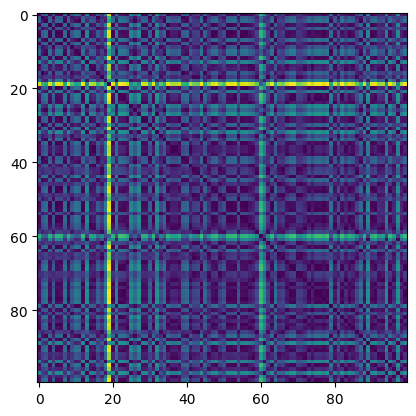

In [122]:
plt.imshow(distance_matrix)

In [126]:
adj_matrix = (distance_matrix < 5000)

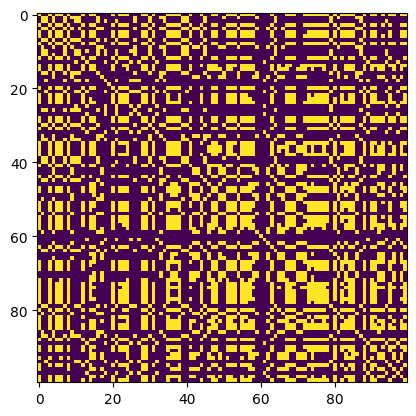

In [127]:
plt.imshow(adj_matrix)

In [182]:
nodes_list = np.arange(num_galaxies)
disconnected_nodes = np.where(np.sum(adj_matrix, axis=0) == 1)[0]
# print(disconnected_nodes)
nodes_list = np.delete(nodes_list, disconnected_nodes)
               

In [183]:
nodes_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [184]:
G = nx.Graph()
G.add_nodes_from(nodes_list)

In [185]:
edge_list = []
for i in range(num_galaxies):
    for j in range(i):
        if adj_matrix[i][j]:
            edge_list.append((i,j))
len(edge_list)

1716

In [186]:
G.add_edges_from(edge_list)

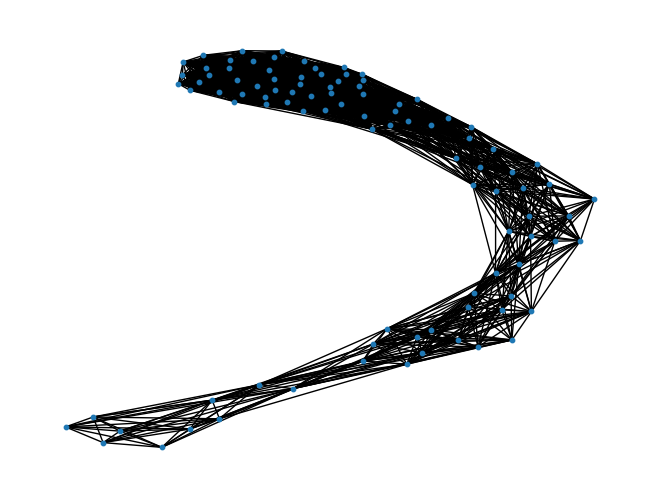

In [188]:
nx.draw(G, node_size=10)